 This notebook will be mainly used for the capstone project!

In [75]:
import pandas as pd
import numpy as np

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import folium

print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Download Toronto's borough data and capture Latitude & Longitude co-ordinates 

In [48]:
canada_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(canada_url).text

canada_soup = BeautifulSoup(source, 'xml')

table_contents=[]
table=canada_soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
canada_df=pd.DataFrame(table_contents)
canada_df['Borough']=canada_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

canada_df=canada_df[canada_df['Borough']!='Not assigned']
temp_df=canada_df.groupby('PostalCode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)
df_merge = pd.merge(canada_df, temp_df, on='PostalCode')
df_merge.drop(['Neighborhood'],axis=1,inplace=True)
df_merge.drop_duplicates(inplace=True)
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)
url='https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv'
canada_df_geo=pd.read_csv(url)
canada_df_geo = canada_df_geo.rename(columns = {'Postal Code':'PostalCode'}) 
canada_df = pd.merge(df_merge, canada_df_geo, on = 'PostalCode')
canada_df1=canada_df[canada_df['Borough'].str.contains('Toronto')]
canada_df1=canada_df1.reset_index(drop=True)


# Create a new column as Label and get the date from 'Borough' as integer
canada_df1['Label']=canada_df1['Borough'].replace(to_replace=['Downtown Toronto','Central Toronto','West Toronto','East Toronto'],value=[1,2,3,4],inplace=False)
canada_df1.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Label
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,4
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1


# Visualize Toronto Map

In [49]:
kclusters=len(canada_df1.Label.unique())

# create map
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(canada_df1['Latitude'], canada_df1['Longitude'], canada_df1['Label']):
    label = folium.Popup(str(canada_df1['Borough']) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
map_toronto

# Define Foursquare Credentials and Version

In [50]:
CLIENT_ID = '5DL255AQYKGMWR4THPNQLHZPSZU4K2U0UZLNXFRHP03DRCUP' # your Foursquare ID
CLIENT_SECRET = 'GL530D5XQCYLEPWWCXBFEKLLABIWLM1DOST52TD0RV1R4MCZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5DL255AQYKGMWR4THPNQLHZPSZU4K2U0UZLNXFRHP03DRCUP
CLIENT_SECRET:GL530D5XQCYLEPWWCXBFEKLLABIWLM1DOST52TD0RV1R4MCZ


## Get Nearby Venues

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
Toronto_venues = getNearbyVenues(names=canada_df1['Neighborhood'],
                                   latitudes=canada_df1['Latitude'],
                                   longitudes=canada_df1['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [56]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1574, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [57]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,70,70,70,70,70,70
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34
Davisville North,8,8,8,8,8,8


In [58]:
print('There are {} unique categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 233 unique categories.


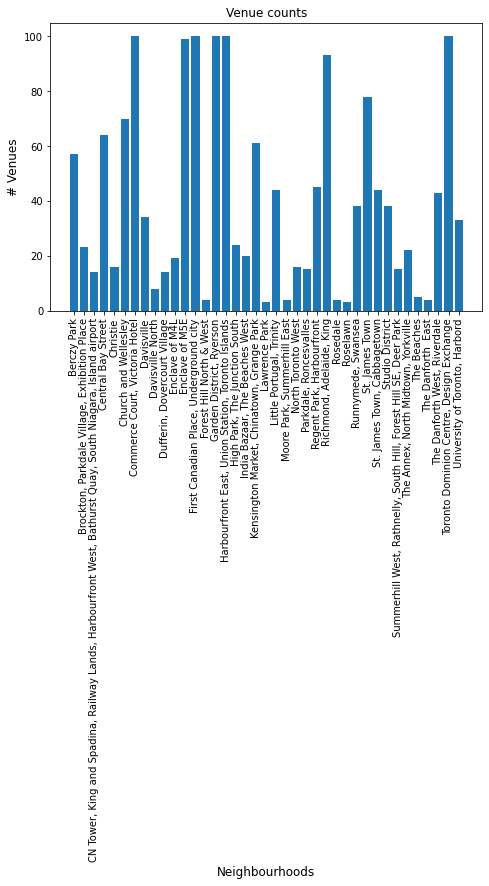

In [61]:
Toronto_counts = Toronto_venues.groupby('Neighborhood').count()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Toronto_counts.index,Toronto_counts.Venue)
plt.xticks(Toronto_counts.index, rotation=90)
# Add title and axis names
plt.title('Venue counts')
plt.xlabel('Neighbourhoods', fontsize='large')
plt.ylabel('# Venues', fontsize='large')
plt.show()

# Analyze each neighborhood

In [65]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.shape

(1574, 233)

In [92]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,Central Bay Street,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0
4,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [68]:
#Function from the course
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Convenience Store,Italian Restaurant,Stadium,Furniture / Home Store,Climbing Gym,Bar,Nightclub
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Airport Food Court,Airport Gate,Airport Terminal,Sculpture Garden,Airport,Plane,Boat or Ferry
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bubble Tea Shop,Thai Restaurant,Department Store,Salad Place,Japanese Restaurant
4,Christie,Grocery Store,Café,Park,Coffee Shop,Nightclub,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store


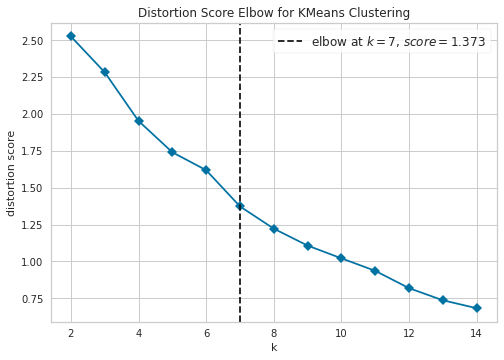

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [82]:
#!conda install -c conda-forge yellowbrick
from yellowbrick.cluster import KElbowVisualizer

#Find optimal number of clusters using the elbow method
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), timings=False)

visualizer.fit(Toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show() 

In [90]:
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0], dtype=int32)

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [94]:
Toronto_merged = canada_df1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,0,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,French Restaurant,Chocolate Shop,Dessert Shop
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,0,Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Bookstore,Japanese Restaurant,Hotel
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,0,Café,Coffee Shop,Cosmetics Shop,Cocktail Bar,Gastropub,Seafood Restaurant,Restaurant,Creperie,Lingerie Store,Moroccan Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,4,Pub,Health Food Store,Pizza Place,Trail,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,0,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall


In [95]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [96]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,0,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,French Restaurant,Chocolate Shop,Dessert Shop
1,Downtown Toronto,1,0,Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Bookstore,Japanese Restaurant,Hotel
2,Downtown Toronto,1,0,Café,Coffee Shop,Cosmetics Shop,Cocktail Bar,Gastropub,Seafood Restaurant,Restaurant,Creperie,Lingerie Store,Moroccan Restaurant
4,Downtown Toronto,1,0,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall
5,Downtown Toronto,1,0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bubble Tea Shop,Thai Restaurant,Department Store,Salad Place,Japanese Restaurant
6,Downtown Toronto,1,0,Grocery Store,Café,Park,Coffee Shop,Nightclub,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store
7,Downtown Toronto,1,0,Coffee Shop,Café,Restaurant,Thai Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Concert Hall,Salad Place
8,West Toronto,3,0,Bakery,Pharmacy,Middle Eastern Restaurant,Bar,Music Venue,Supermarket,Café,Bank,Brewery,Park
10,Downtown Toronto,1,0,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Scenic Lookout,Sporting Goods Shop,Brewery,Italian Restaurant,Fried Chicken Joint
11,West Toronto,3,0,Bar,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Restaurant,Coffee Shop,Café,Gift Shop,Beer Store


In [101]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,2,1,Restaurant,Lawyer,Trail,Tennis Court,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant


In [102]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,2,Garden,Fast Food Restaurant,Pool,Yoga Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


In [103]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,East Toronto,4,3,Park,Pet Store,Italian Restaurant,Brewery,Fish & Chips Shop,Sandwich Place,Food & Drink Shop,Liquor Store,Light Rail Station,Steakhouse
20,Central Toronto,2,3,Food & Drink Shop,Department Store,Breakfast Spot,Gym / Fitness Center,Gym,Sandwich Place,Hotel,Park,Monument / Landmark,Molecular Gastronomy Restaurant
38,East Toronto Business,East Toronto Business,3,Light Rail Station,Yoga Studio,Auto Workshop,Smoke Shop,Burrito Place,Spa,Fast Food Restaurant,Farmers Market,Garden,Garden Center


In [104]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Toronto,4,4,Pub,Health Food Store,Pizza Place,Trail,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop


In [105]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,5,Park,Bus Line,Swim School,Yoga Studio,Movie Theater,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [106]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,East York/East Toronto,6,Park,Convenience Store,Metro Station,Yoga Studio,Museum,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
33,Downtown Toronto,1,6,Park,Playground,Trail,Yoga Studio,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant


In [109]:
canada_df2 = Toronto_merged[~Toronto_merged['1st Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['2nd Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['3rd Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['4th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['5th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['6th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['7th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['8th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['9th Most Common Venue'].str.contains("Toronto", na=False) & 
                    ~Toronto_merged['10th Most Common Venue'].str.contains("Toronto", na=False)]
canada_df2[canada_df2['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.38316,2,1,Restaurant,Lawyer,Trail,Tennis Court,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant
